## Семинар 7: "Методы оптимизации"

ФИО: Акишин Кирилл Алексеевич

In [1]:
import numpy as np
#from sklearn.datasets import fetch_mldata
#from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import seaborn as sns
%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [3]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = parameters

    def zero_grad(self):
        for param in self.parameters:
            try:
                param.grad.zero_()
            except:
                pass
  
    def step(self, F):
        loss = F()
        loss.backward()

class SGD(Optimizer):
    def __init__(self, parameters, lr=0.1):
        self.parameters = parameters
        self.lr = lr
  
    def step(self, F):
        super().step(F)

        with torch.no_grad():
            for param in self.parameters:      
                param -= self.lr * param.grad
                #param.__idiff__(self.lr * param.grad)
                #param = param - self.lr * param.grad
                #param.set_(param - self.lr * param.grad)

class Momentum(Optimizer):
    def __init__(self, parameters, lr=0.1, gamma=0.9):
        self.parameters = parameters    
        self.params_step = [torch.zeros_like(param) for param in self.parameters]

        self.lr = lr
        self.gamma = gamma
  
    def step(self, F):
        super().step(F)

        with torch.no_grad():
            for param, step in zip(self.parameters, self.params_step):
                step.set_(self.gamma * step + self.lr * param.grad)
                param -= step

class NAG(Optimizer):
    def __init__(self, parameters, lr=0.1, gamma=0.9):
        self.parameters = parameters    
        self.params_step = [torch.zeros_like(param) for param in self.parameters]

        self.lr = lr
        self.gamma = gamma
  
    def step(self, F):
        with torch.no_grad():
            for param, step in zip(self.parameters, self.params_step):
                param -= self.gamma * step

        super().step(F)

        with torch.no_grad():
            for param, step in zip(self.parameters, self.params_step):
                param += self.gamma * step
        
                step.set_(self.gamma * step + self.lr * param.grad)
                param -= step

class Adadelta(Optimizer):
    def __init__(self, parameters, gamma=0.9):
        self.parameters = parameters    
        self.params_gs = [torch.zeros_like(param) for param in self.parameters]

        self.first_call = True    

        self.lr = 1
        self.gamma = gamma
        self.eps = 0.00001
  
    def step(self, F):
        super().step(F)

        sum_step = 0
        num_params = 0
        with torch.no_grad():
            for param, gs in zip(self.parameters, self.params_gs):
                if self.first_call:
                    gs.set_(param.grad**2)
                else:
                    gs.set_(self.gamma * gs + (1.0 - self.gamma) * param.grad**2)

                step = self.lr / (gs + self.eps).sqrt() * param.grad

                sum_step += step.sum()
                num_params += step.numel()

                param -= step

            self.lr = self.gamma * self.lr + (1 - self.gamma) * sum_step / num_params

            self.first_call = False

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [41]:
# sin(x) + cos(y)

def f(x):
  # return x[0].sin() + x[1].cos() + (x.sum())**2
  return (x**2).sum(axis=-1)

optimizers = [(SGD, "red"), (Momentum, "green"), (NAG, "blue"), (Adadelta, "black")]

all_ways = []

for optimizer, _ in optimizers:
  x = nn.Parameter(torch.tensor([0.5, 0.7]))
  optimizer = optimizer([x])

  points = []
  for i in range(5):  
      optimizer.zero_grad()
      optimizer.step(lambda x=x: f(x))

      points.append(x.detach().numpy().copy())
      #print(points[-1])

  print(f(x))

  points = np.array(points)
  all_ways.append(points)

tensor(0.0795, grad_fn=<SumBackward1>)
tensor(0.2493, grad_fn=<SumBackward1>)
tensor(0.0500, grad_fn=<SumBackward1>)
tensor(0.0099, grad_fn=<SumBackward1>)


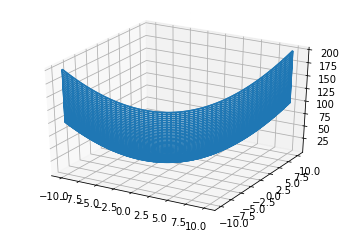

In [42]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = numpy.result_type(*arrays)
    arr = numpy.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(numpy.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

size = 10
n = 100

X = np.linspace(-size, size, n)
Y = np.linspace(-size, size, n)

Z = f(cartesian_product(X, Y)).reshape(n, n)

#print(Z)

#ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.plot_wireframe(X, Y, Z)

plt.show()

(-0.5499942749738693,
 0.5499899238348007,
 -0.45460868775844576,
 0.6083147019147873)

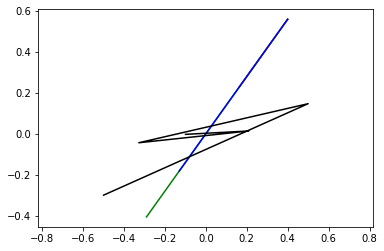

In [43]:
for points, (_, color) in zip(all_ways, optimizers):
  plt.plot(points[:, 0], points[:, 1], c=color)

plt.axis('equal')

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [47]:
# sin(x) + cos(y)

def f(x):
  # print(x)
  # return x[0].sin() + x[1].cos() + (x.sum())**2
  return (x**2 * torch.sin(x)).sum(axis=-1)
  # return (x[0]**2*torch.sin(x[0]) + x[1]**2*torch.sin(x[1]))

optimizers = [(SGD, "red"), (Momentum, "green"), (NAG, "blue"), (Adadelta, "black")]

all_ways = []

for optimizer, _ in optimizers:
  x = nn.Parameter(torch.tensor([0.5, 0.7]))
  optimizer = optimizer([x])

  points = []
  for i in range(5):  
      optimizer.zero_grad()
      optimizer.step(lambda x=x: f(x))

      points.append(x.detach().numpy().copy())
      #print(points[-1])

  print(f(x))

  points = np.array(points)
  all_ways.append(points)

tensor(0.0557, grad_fn=<SumBackward1>)
tensor(-0.0157, grad_fn=<SumBackward1>)
tensor(-0.0004, grad_fn=<SumBackward1>)
tensor(-1.4882, grad_fn=<SumBackward1>)


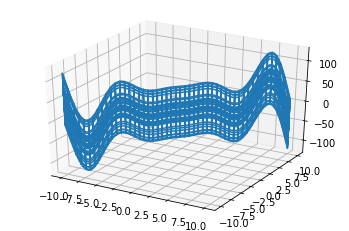

In [48]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = numpy.result_type(*arrays)
    arr = numpy.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(numpy.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

size = 10
n = 100

X = np.linspace(-size, size, n)
Y = np.linspace(-size, size, n)

Z = f(torch.from_numpy(cartesian_product(X, Y))).reshape(n, n)

#print(Z)

#ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.plot_wireframe(X, Y, Z)

plt.show()

(-4.252785815298557,
 0.6531132891774177,
 -3.2090273559093476,
 0.7523970067501068)

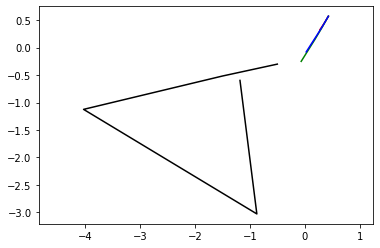

In [49]:
for points, (_, color) in zip(all_ways, optimizers):
  plt.plot(points[:, 0], points[:, 1], c=color)

plt.axis('equal')

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [50]:
# sin(x) + cos(y)

def f(x):
  # print(x)
  # return x[0].sin() + x[1].cos() + (x.sum())**2
  return (x**2 * torch.sin(x**2)).sum(axis=-1)
  # return (x[0]**2*torch.sin(x[0]) + x[1]**2*torch.sin(x[1]))

optimizers = [(SGD, "red"), (Momentum, "green"), (NAG, "blue"), (Adadelta, "black")]

all_ways = []

for optimizer, _ in optimizers:
  x = nn.Parameter(torch.tensor([0.5, 0.7]))
  optimizer = optimizer([x])

  points = []
  for i in range(5):  
      optimizer.zero_grad()
      optimizer.step(lambda x=x: f(x))

      points.append(x.detach().numpy().copy())
      #print(points[-1])

  print(f(x))

  points = np.array(points)
  all_ways.append(points)

tensor(0.0364, grad_fn=<SumBackward1>)
tensor(0.0004, grad_fn=<SumBackward1>)
tensor(0.0007, grad_fn=<SumBackward1>)
tensor(0.0006, grad_fn=<SumBackward1>)


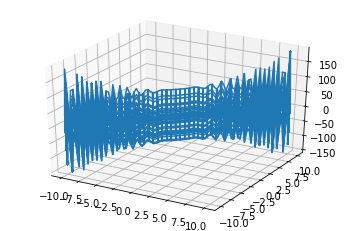

In [51]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = numpy.result_type(*arrays)
    arr = numpy.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(numpy.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

size = 10
n = 100

X = np.linspace(-size, size, n)
Y = np.linspace(-size, size, n)

Z = f(torch.from_numpy(cartesian_product(X, Y))).reshape(n, n)

#print(Z)

#ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.plot_wireframe(X, Y, Z)

plt.show()

(-0.5499724835157395,
 0.5498824208974838,
 -0.3436759740114212,
 0.6172633796930314)

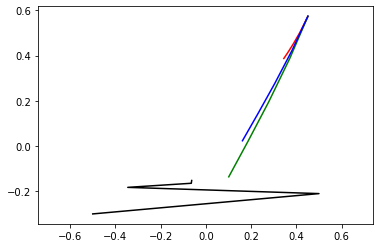

In [52]:
for points, (_, color) in zip(all_ways, optimizers):
  plt.plot(points[:, 0], points[:, 1], c=color)

plt.axis('equal')

###  Часть 2: Обучение нейронной сети

In [55]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader


# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [83]:
def train(network, epochs, optimizer):
    loss = nn.NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [101]:
from torch import nn

class LinClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()    
        
        channels = 1
        
        self.lin_layers = nn.Sequential(
            nn.Linear(image_size*image_size, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
            nn.ReLU(),
        )
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.lin_layers(x)
        return self.log_softmax(x)

Epoch 4... (Train/Test) NLL: 0.626/0.607	Accuracy: 0.843/0.851


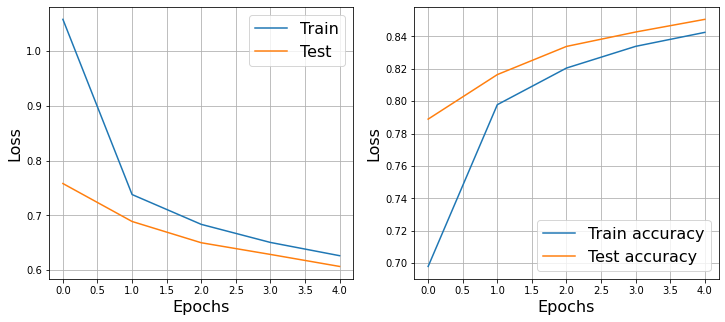

In [102]:
# Adam

network = LinClassifier(image_size=28)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
train(network, 5, optimizer)

Epoch 4... (Train/Test) NLL: 0.886/0.827	Accuracy: 0.824/0.840


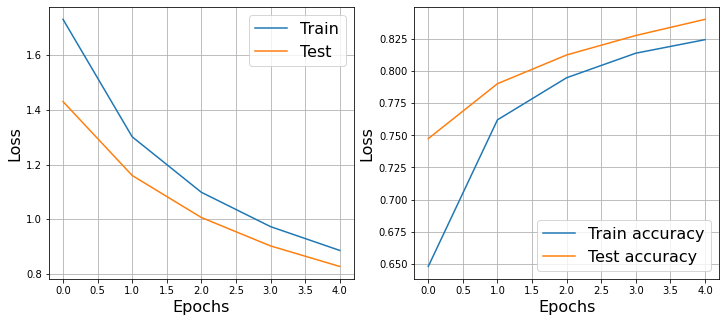

In [106]:
# Adagrad

network = LinClassifier(image_size=28)
optimizer = torch.optim.Adagrad(network.parameters(), lr=1e-4)
train(network, 5, optimizer)

Epoch 4... (Train/Test) NLL: 2.213/2.200	Accuracy: 0.321/0.348


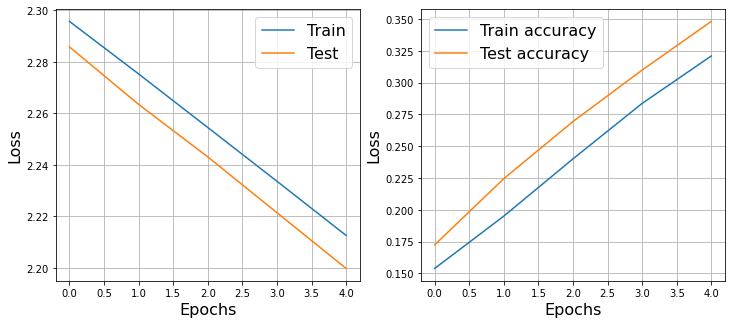

In [107]:
# AdaDelta

network = LinClassifier(image_size=28)
optimizer = torch.optim.Adadelta(network.parameters(), lr=1e-4)
train(network, 5, optimizer)

Epoch 4... (Train/Test) NLL: 2.123/2.096	Accuracy: 0.382/0.408


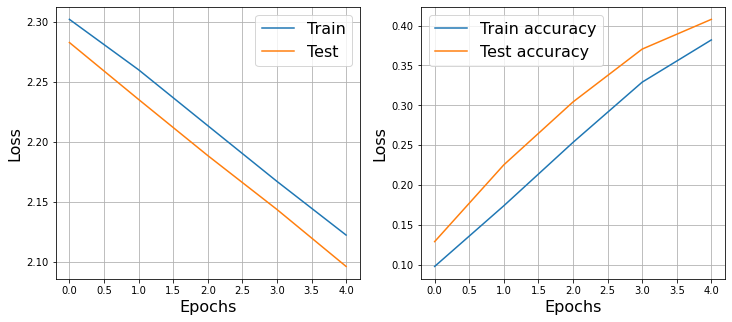

In [108]:
# SGD

network = LinClassifier(image_size=28)
optimizer = torch.optim.SGD(network.parameters(), lr=1e-4)
train(network, 5, optimizer)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [84]:
from torch import nn
from IPython.display import clear_output

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), nn.ReLU(), 
                                         nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), 
                                         nn.Conv2d(16, 32, 3, padding=1), 
                                         )
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*32, 10), nn.LogSoftmax(dim=1))
        # self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*8*16, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.110/0.087	Accuracy: 0.968/0.975


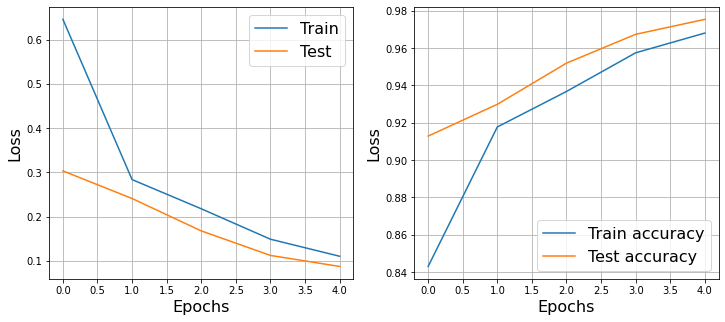

In [86]:
# Adam

network = ConvClassifier(image_size=28)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
train(network, 5, optimizer)

Epoch 4... (Train/Test) NLL: 0.696/0.635	Accuracy: 0.839/0.853


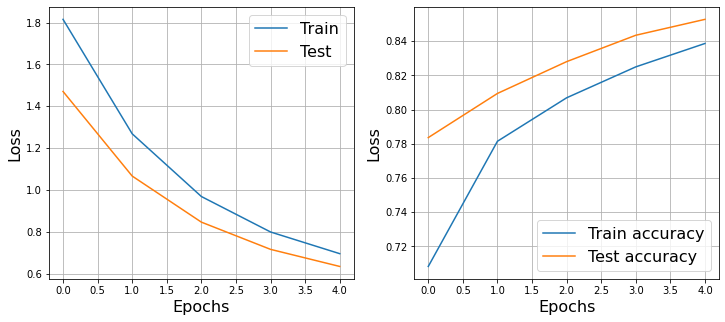

In [87]:
# Adagrad

network = ConvClassifier(image_size=28)
optimizer = torch.optim.Adagrad(network.parameters(), lr=1e-4)
train(network, 5, optimizer)

Epoch 4... (Train/Test) NLL: 2.248/2.240	Accuracy: 0.268/0.327


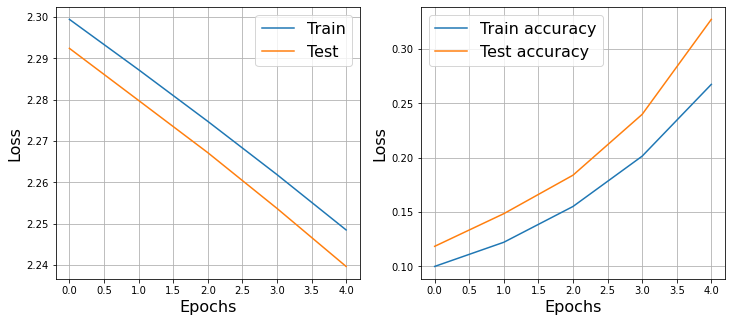

In [91]:
# AdaDelta

network = ConvClassifier(image_size=28)
optimizer = torch.optim.Adadelta(network.parameters(), lr=1e-4)
train(network, 5, optimizer)

Epoch 4... (Train/Test) NLL: 2.184/2.163	Accuracy: 0.573/0.595


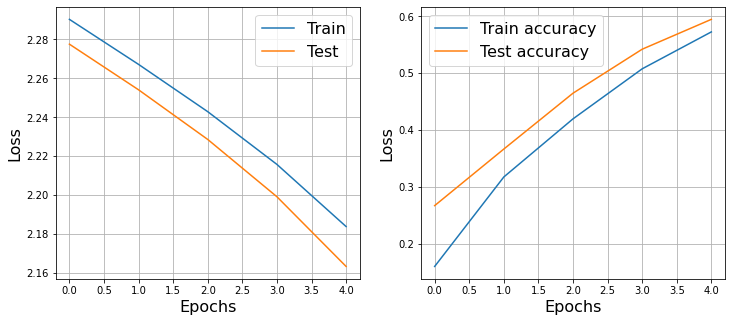

In [90]:
# SGD

network = ConvClassifier(image_size=28)
optimizer = torch.optim.SGD(network.parameters(), lr=1e-4)
train(network, 5, optimizer)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: